# K-Means & Hierarchical Clustering

#### Data Sources: https://github.com/owid/covid-19-data/tree/master/public/data
####               https://en.wikipedia.org/wiki/World_Happiness_Report

**Amacimiz ulkeleri clusterlara ayirmak: Gelismis, Az gelismis, Geri kalmis vs gibi**

In [1205]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from pyclustertend import hopkins
from sklearn.preprocessing import scale
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples,silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

In [1206]:
cnt = pd.read_csv ("countries.csv")
cnt.sample(10)

,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index
172,Trinidad and Tobago,1399491,266.886,36.2,10.014,5.819,28763.071,NaN,73.51,0.784
154,Solomon Islands,686878,21.841,20.8,3.507,2.043,2205.923,25.1,73.00,0.546
181,Uzbekistan,33469199,76.134,28.2,4.469,2.873,6253.104,NaN,71.72,0.710
92,Latvia,1886202,31.212,43.9,19.754,14.136,25063.846,0.7,75.29,0.847
140,Saint Kitts and Nevis,53192,212.865,NaN,NaN,NaN,24654.385,NaN,76.23,0.778
11,Bahamas,393248,39.497,34.3,8.996,5.200,27717.847,NaN,73.92,0.807
8,Australia,25499881,3.202,37.9,15.504,10.129,44648.710,0.5,83.44,0.939
77,Indonesia,273523621,145.725,29.3,5.319,3.053,11188.744,5.7,71.72,0.694
14,Barbados,287371,664.463,39.8,14.952,9.473,16978.068,NaN,79.19,0.800
161,Sudan,43849269,23.258,19.7,3.548,2.034,4466.507,NaN,65.31,0.502


In [1207]:
cnt.columns

Index(['location', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [1208]:
happy_scores = pd.read_csv('happiness_scores.csv')
happy_scores.head()

,location,happiness_score
0,Finland,7.809
1,Denmark,7.646
2,Switzerland,7.560
3,Iceland,7.504
4,Norway,7.488


In [1209]:
df = pd.merge(cnt, happy_scores, on = "location", how = "left")
df.head()

,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
0,Afghanistan,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,64.83,0.498,2.567
1,Albania,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,78.57,0.785,4.883
2,Algeria,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,76.88,0.754,5.005
3,Andorra,77265,163.755,NaN,NaN,NaN,NaN,NaN,83.73,0.858,NaN
4,Angola,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,61.15,0.581,NaN


# EDA

In [1210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 0 to 189
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   location                 190 non-null    object 
 1   population               190 non-null    int64  
 2   population_density       186 non-null    float64
 3   median_age               181 non-null    float64
 4   aged_65_older            179 non-null    float64
 5   aged_70_older            180 non-null    float64
 6   gdp_per_capita           182 non-null    float64
 7   extreme_poverty          124 non-null    float64
 8   life_expectancy          189 non-null    float64
 9   human_development_index  183 non-null    float64
 10  happiness_score          149 non-null    float64
dtypes: float64(9), int64(1), object(1)
memory usage: 17.8+ KB


In [1211]:
def null_values(df):
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

null_values(df)

,Missing_Records,Percentage (%)
extreme_poverty,66,34.736842
happiness_score,41,21.578947
aged_65_older,11,5.789474
aged_70_older,10,5.263158
median_age,9,4.736842
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
population_density,4,2.105263
life_expectancy,1,0.526316


In [1212]:
df.describe()

,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
count,1.900000e+02,186.000000,181.000000,179.000000,180.000000,182.000000,124.000000,189.000000,183.000000,149.000000
mean,8.183077e+07,341.658210,30.204972,8.590022,5.436161,18439.706637,13.916129,72.862011,0.708869,5.472221
std,5.819950e+08,1612.572496,9.171031,6.198639,4.225454,19589.091950,20.311975,7.584835,0.154410,1.125246
min,8.090000e+02,1.980000,15.100000,1.144000,0.526000,661.240000,0.100000,53.280000,0.354000,2.567000
25%,2.367885e+06,35.972500,21.700000,3.421500,2.033500,3924.303000,0.600000,67.270000,0.588500,4.677000
50%,9.493482e+06,82.464000,29.400000,6.211000,3.541500,11822.138500,2.350000,74.250000,0.736000,5.515000
75%,3.076120e+07,208.157000,38.700000,14.053000,8.651750,26069.050500,21.675000,77.970000,0.823000,6.258000
max,7.794799e+09,19347.500000,48.200000,27.049000,18.493000,116935.600000,77.600000,86.750000,0.953000,7.809000


> * [min-population], [max-population], [max-population_density],[min-gdp_per_capita],[max-extreme_poverty] have anomaly

In [1213]:
df[(df["population"] < 1000) | (df["population"] > 1000000000) | (df["population_density"] > 15000)]

,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
35,China,1439323774,147.674,38.7,10.641,5.929,15308.712,0.7,76.91,0.752,5.124
76,India,1380004385,450.419,28.2,5.989,3.414,6426.674,21.2,69.66,0.640,3.573
111,Monaco,39244,19347.500,NaN,NaN,NaN,NaN,NaN,86.75,NaN,NaN
183,Vatican,809,NaN,NaN,NaN,NaN,NaN,NaN,75.12,NaN,NaN
186,World,7794798729,58.045,30.9,8.696,5.355,15469.207,10.0,72.58,NaN,NaN


In [1214]:
df[(df["gdp_per_capita"] < 1000) | (df["extreme_poverty"] > 70)]

,location,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
27,Burundi,11890781,423.062,17.5,2.562,1.504,702.225,71.7,61.58,0.417,3.775
32,Central African Republic,4829764,7.479,18.3,3.655,2.251,661.240,NaN,53.28,0.367,3.476
44,Democratic Republic of Congo,89561404,35.879,17.0,3.020,1.745,808.133,77.1,60.68,0.457,5.194
95,Liberia,5057677,49.127,19.2,3.057,1.756,752.788,38.6,64.10,0.435,4.558
100,Madagascar,27691019,43.951,19.6,2.929,1.686,1416.440,77.6,67.04,0.519,4.166
101,Malawi,19129955,197.519,18.1,2.979,1.783,1095.042,71.4,64.26,0.477,3.538
122,Niger,24206636,16.955,15.1,2.553,1.378,926.000,44.5,62.42,0.354,4.910


In [1215]:
df.set_index("location", inplace = True)

In [1216]:
df.head()

,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
location,,,,,,,,,,
Afghanistan,38928341,54.422,18.6,2.581,1.337,1803.987,NaN,64.83,0.498,2.567
Albania,2877800,104.871,38.0,13.188,8.643,11803.431,1.1,78.57,0.785,4.883
Algeria,43851043,17.348,29.1,6.211,3.857,13913.839,0.5,76.88,0.754,5.005
Andorra,77265,163.755,NaN,NaN,NaN,NaN,NaN,83.73,0.858,NaN
Angola,32866268,23.890,16.8,2.405,1.362,5819.495,NaN,61.15,0.581,NaN


In [1217]:
# sns.pairplot(df);

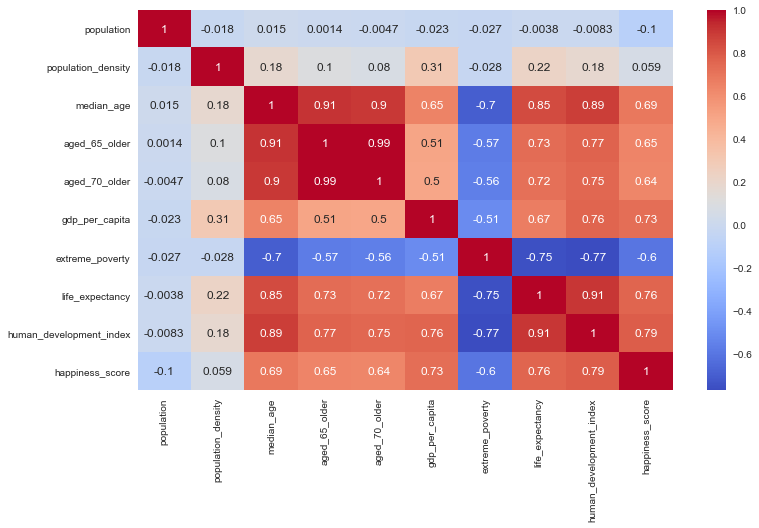

In [1218]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True, cmap="coolwarm");

In [1219]:
df.columns

Index(['population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'life_expectancy',
       'human_development_index', 'happiness_score'],
      dtype='object')

In [1220]:
df= df[['median_age', 
#              'population', # belirleyici sutun degil
#              'population_density', #  # belirleyici sutun degil
             'aged_65_older',
#              'aged_70_older', # aged_65_older ile benzer
             'gdp_per_capita', 
             'extreme_poverty', 
             'life_expectancy',
             'human_development_index', 
             'happiness_score']]
df.sample(10)

,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
location,,,,,,,
Belarus,40.3,14.799,17167.967,NaN,74.79,0.808,5.540
Mauritius,37.4,10.945,20292.745,0.5,74.99,0.790,6.101
Kazakhstan,30.6,6.991,24055.588,0.1,73.60,0.800,6.058
Malawi,18.1,2.979,1095.042,71.4,64.26,0.477,3.538
Jordan,23.2,3.810,8337.490,0.1,74.53,0.735,4.633
Thailand,40.1,11.373,16277.671,0.1,77.15,0.755,5.999
Jamaica,31.4,9.684,8193.571,NaN,74.47,0.732,5.890
Saint Lucia,34.9,9.721,12951.839,NaN,76.20,0.747,NaN
Argentina,31.9,11.198,18933.907,0.6,76.67,0.825,5.975


In [1221]:
df.dropna(how='all',inplace=True) # drop all rows with all columns Nan

In [1222]:
null_values(df)

,Missing_Records,Percentage (%)
extreme_poverty,66,34.736842
happiness_score,41,21.578947
aged_65_older,11,5.789474
median_age,9,4.736842
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
life_expectancy,1,0.526316


In [1223]:
df.loc["World"]

median_age                    30.900
aged_65_older                  8.696
gdp_per_capita             15469.207
extreme_poverty               10.000
life_expectancy               72.580
human_development_index          NaN
happiness_score                  NaN
Name: World, dtype: float64

> **Let's focus the columns with nan values separately**

### extreme_poverty
* Lets fill in NAN values according to the column with the highest correlation with this column.

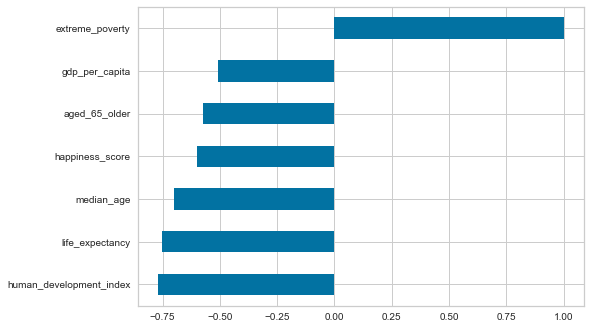

In [1224]:
df.corr()["extreme_poverty"].sort_values().plot.barh();

In [1225]:
def k_score(df, col_name):
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans
    
    df_new=df.copy()
    df_new[df_new[col_name].isnull()]=1000000
    df_new = df_new[col_name].values.reshape(-1, 1)
    kmeans = KMeans()
    visu = KElbowVisualizer(kmeans, k=(2, 10))
    visu.fit(df_new)
    visu.poof()

In [1226]:
def fill(df, group_col, col_name, num_of_clusters):
    from sklearn.cluster import KMeans
    
    df_new=df.copy()
    df_new[df_new[group_col].isnull()]=1000000
    df_new = df_new[group_col].values.reshape(-1, 1)
    kmeans_model = KMeans(n_clusters= num_of_clusters).fit(df_new)
    df_new_pred = kmeans_model.predict(df_new)
    df[group_col+'_clusters'] = df_new_pred
    df[col_name] = df.groupby(group_col+'_clusters')[col_name].apply(lambda x: x.fillna(x.mean()))
    print(f'Number of NaN : {df[col_name].isnull().sum()} in "{col_name}" column.\n------------------')
    return df[df.extreme_poverty.isnull()]
    

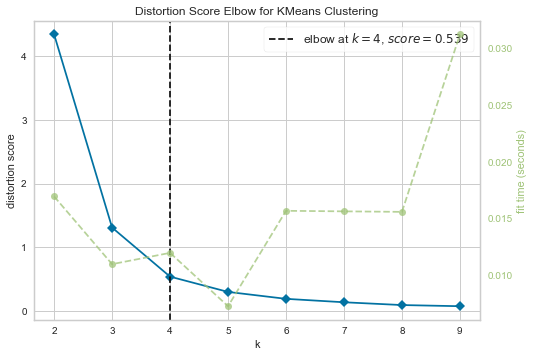

In [1227]:
k_score(df,'human_development_index')

In [1228]:
fill(df,'human_development_index','extreme_poverty',4)

Number of NaN : 0 in "extreme_poverty" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters
location,,,,,,,,


In [1229]:
# df.dropna(subset=['extreme_poverty'],inplace=True)

In [1230]:
null_values(df)

,Missing_Records,Percentage (%)
happiness_score,41,21.578947
aged_65_older,11,5.789474
median_age,9,4.736842
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
life_expectancy,1,0.526316


### happiness_score	

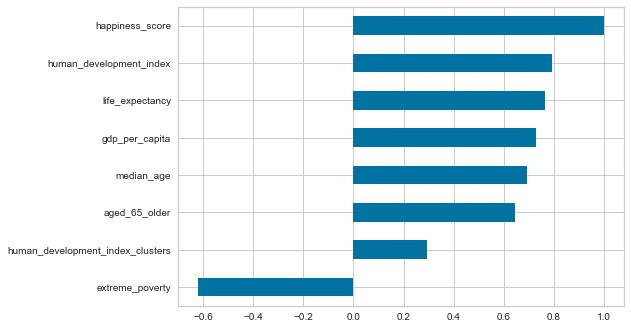

In [1231]:
df.corr()["happiness_score"].sort_values().plot.barh();

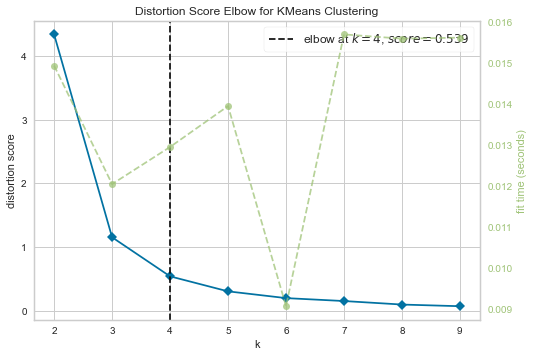

In [1232]:
k_score(df,'human_development_index')

In [1233]:
fill(df,'human_development_index','happiness_score',4)

Number of NaN : 0 in "happiness_score" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters
location,,,,,,,,


In [1234]:
null_values(df)

,Missing_Records,Percentage (%)
aged_65_older,11,5.789474
median_age,9,4.736842
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
life_expectancy,1,0.526316


### aged_65_older

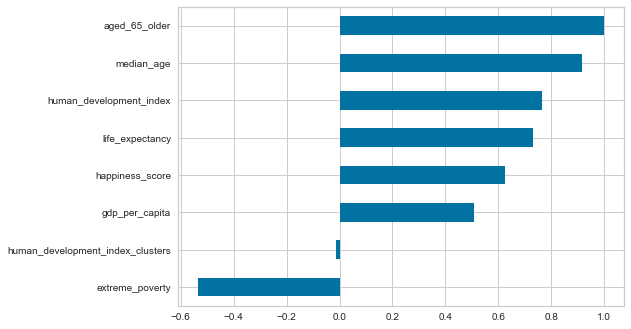

In [1235]:
df.corr()["aged_65_older"].sort_values().plot.barh();

In [1236]:
df[df.aged_65_older.isnull()][['median_age','aged_65_older']]

,median_age,aged_65_older
location,,
Andorra,NaN,NaN
Dominica,NaN,NaN
Kosovo,NaN,NaN
Liechtenstein,NaN,NaN
Marshall Islands,NaN,NaN
Monaco,NaN,NaN
Saint Kitts and Nevis,NaN,NaN
San Marino,NaN,NaN
Syria,21.7,NaN


> 'aged_65_older' in Nan oldugu yerde "median_age" de Nan oldugundan, filling i 'median_age' e gore yapamayiz

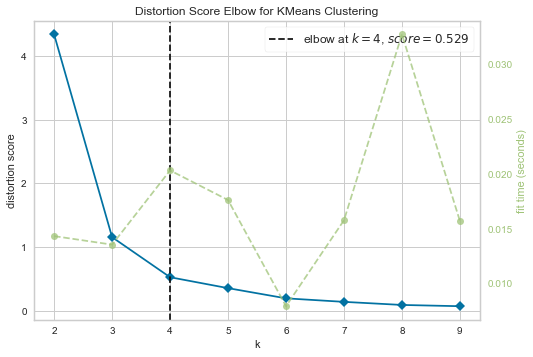

In [1237]:
k_score(df,'human_development_index')

In [1238]:
fill(df,'human_development_index','aged_65_older',4)

Number of NaN : 0 in "aged_65_older" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters
location,,,,,,,,


In [1239]:
null_values(df)

,Missing_Records,Percentage (%)
median_age,9,4.736842
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
life_expectancy,1,0.526316


### median_age

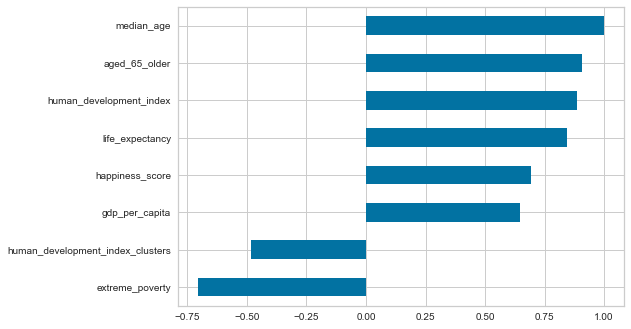

In [1240]:
df.corr()["median_age"].sort_values().plot.barh();

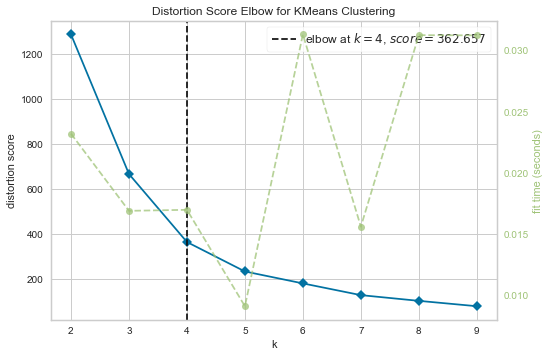

In [1241]:
k_score(df,'aged_65_older')

In [1242]:
fill(df,'aged_65_older','median_age',4)

Number of NaN : 0 in "median_age" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters,aged_65_older_clusters
location,,,,,,,,,


In [1243]:
null_values(df)

,Missing_Records,Percentage (%)
gdp_per_capita,8,4.210526
human_development_index,7,3.684211
life_expectancy,1,0.526316


### gdp_per_capita

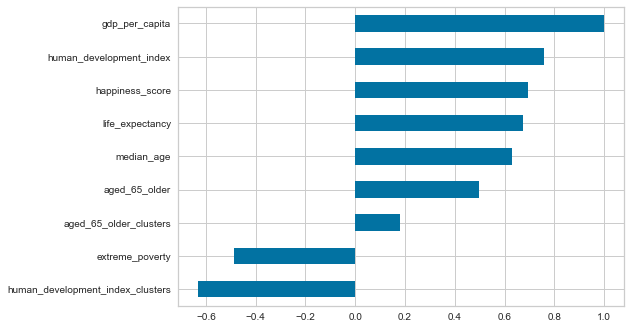

In [1244]:
df.corr()["gdp_per_capita"].sort_values().plot.barh();

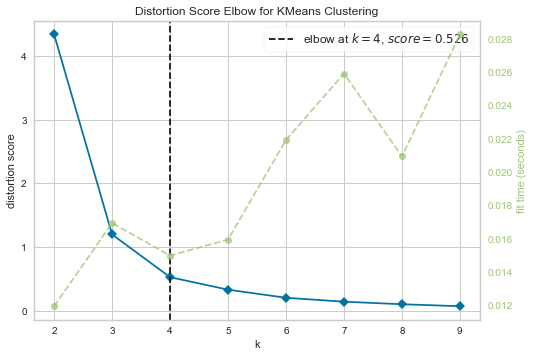

In [1245]:
k_score(df,'human_development_index')

In [1246]:
fill(df,'human_development_index','gdp_per_capita',4)

Number of NaN : 0 in "gdp_per_capita" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters,aged_65_older_clusters
location,,,,,,,,,


In [1247]:
null_values(df)

,Missing_Records,Percentage (%)
human_development_index,7,3.684211
life_expectancy,1,0.526316


### human_development_index

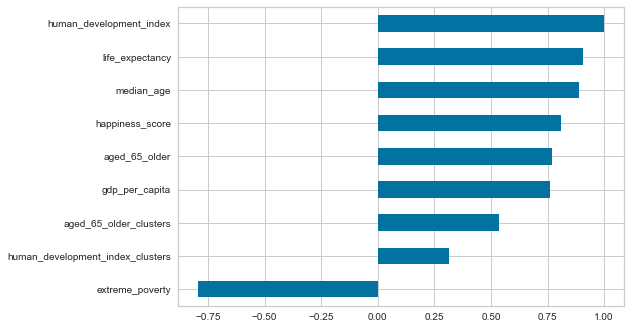

In [1248]:
df.corr()["human_development_index"].sort_values().plot.barh();

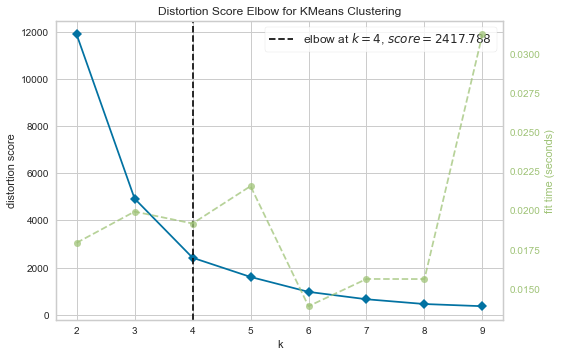

In [1249]:
k_score(df,'extreme_poverty')

In [1250]:
fill(df,'extreme_poverty','human_development_index',4)

Number of NaN : 0 in "human_development_index" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters,aged_65_older_clusters,extreme_poverty_clusters
location,,,,,,,,,,


In [1251]:
null_values(df)

,Missing_Records,Percentage (%)
life_expectancy,1,0.526316


### life_expectancy

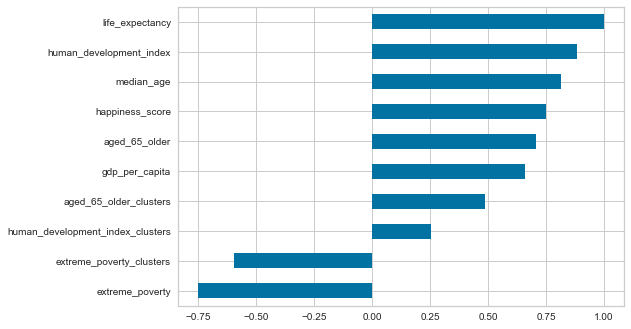

In [1252]:
df.corr()["life_expectancy"].sort_values().plot.barh();

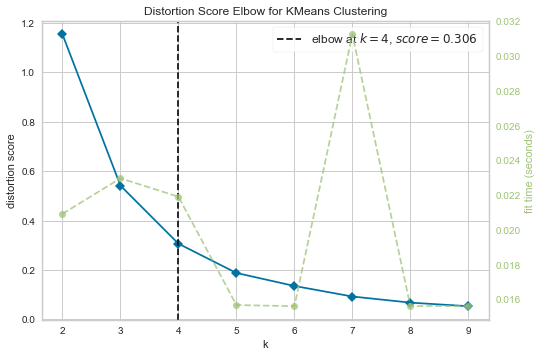

In [1253]:
k_score(df,'human_development_index')

In [1254]:
fill(df,'human_development_index','life_expectancy',4)

Number of NaN : 0 in "life_expectancy" column.
------------------


,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,human_development_index_clusters,aged_65_older_clusters,extreme_poverty_clusters
location,,,,,,,,,,


In [1255]:
null_values(df)

,Missing_Records,Percentage (%)


### Drop useless columns

In [1256]:
df.columns

Index(['median_age', 'aged_65_older', 'gdp_per_capita', 'extreme_poverty',
       'life_expectancy', 'human_development_index', 'happiness_score',
       'human_development_index_clusters', 'aged_65_older_clusters',
       'extreme_poverty_clusters'],
      dtype='object')

In [1257]:
df.drop(['human_development_index_clusters', 
         'aged_65_older_clusters', 
         'extreme_poverty_clusters'],axis=1,inplace=True)

In [1258]:
df.isnull().sum()

median_age                 0
aged_65_older              0
gdp_per_capita             0
extreme_poverty            0
life_expectancy            0
human_development_index    0
happiness_score            0
dtype: int64

## Modelling
### Hopkins Score
* Zaman ve maliyet verimliliği için, İlk olarak Veride kümeleme eğilimi var mi yok mu belirlemek için ``Hopkins Testi`` yapılır.
* Null Hypothesis(Ho) ve Alternative Hypothesis(Ha) temeline dayaniyor.
* Null Hypothesis(Ho): Uniform dagilim var, anlamli kümeleme yok.
* Alternative Hypothesis(Ha):  Veri, ratsgele veri noktalarindan oluşur. Yani Kumeleme vardir.
* [0,1] araliginda bir score verir. score, 0’a yaklaştıkça veri uniform degil,yani clusteringe meyilli
* 1’e yaklaştıkça uniform yapi var, 0.5 gecmedikce kümelenebilir olarak ifade edilir. pratikte 0.3 sinir alinir.

In [1259]:
df.head()

,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score
location,,,,,,,
Afghanistan,18.60,2.581000,1803.987000,37.120513,64.83,0.498,2.567000
Albania,38.00,13.188000,11803.431000,1.100000,78.57,0.785,4.883000
Algeria,29.10,6.211000,13913.839000,0.500000,76.88,0.754,5.005000
Andorra,39.75,15.823551,37844.995123,0.730556,83.73,0.858,6.373400
Angola,16.80,2.405000,5819.495000,37.120513,61.15,0.581,4.292795


In [1260]:
from pyclustertend import hopkins
from sklearn.preprocessing import scale

In [1261]:
hopkins(df,df.shape[0])

0.17656872582419159

In [1262]:
hopkins(scale(df),df.shape[0]) #standart scaler alternatifidir.

0.14565416930725783

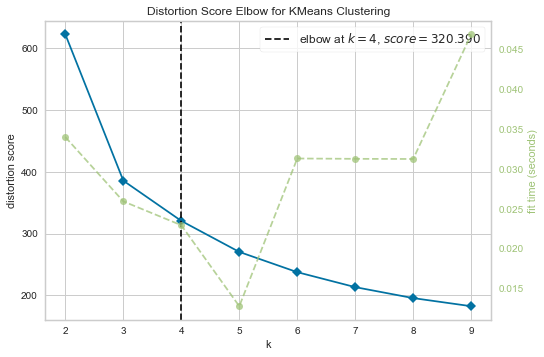

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1263]:
kmeans = KMeans()

visu = KElbowVisualizer(kmeans, k=(2, 10))
visu.fit(scale(df))
visu.poof()

### Scaling

In [1264]:
df_scaled=scale(df)

### K-Means

In [1265]:
kmeans_model = KMeans(n_clusters=3, random_state=42).fit(df_scaled)

In [1266]:
labels=kmeans_model.labels_
labels

# alternative
# df_pred = kmeans_model.predict(df)
# df_pred

array([2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0,
       1, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 2, 0, 0, 0,
       2, 0, 2, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 1, 0, 2, 0,
       1, 1, 2, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2,
       1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 1, 2, 1,
       1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 2, 0, 0, 0,
       2, 1, 1, 0, 2, 0, 1, 2, 1, 0, 0, 2, 0, 1, 2, 1, 2, 2, 1, 1, 1, 2,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2])

In [1267]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([54, 84, 52], dtype=int64))

In [1268]:
from sklearn.metrics import silhouette_score
silhouette_score(df_scaled, labels)

0.4156751720598783

In [1269]:
df['Kmeans_clusters'] = labels
df.sample(5)

,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,Kmeans_clusters
location,,,,,,,,
South Korea,43.4,13.914,35938.374,0.20000,83.03,0.903,5.872,0
Philippines,25.2,4.803,7599.188,5.12766,71.23,0.699,6.006,1
Kazakhstan,30.6,6.991,24055.588,0.10000,73.60,0.800,6.058,1
Gambia,17.5,2.339,1561.767,10.10000,62.05,0.460,4.751,2
Greece,45.3,20.396,24574.382,1.50000,82.24,0.870,5.515,0


## Hierarchy Clustering

In [1270]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [1271]:
linked = linkage(df_scaled, "ward")

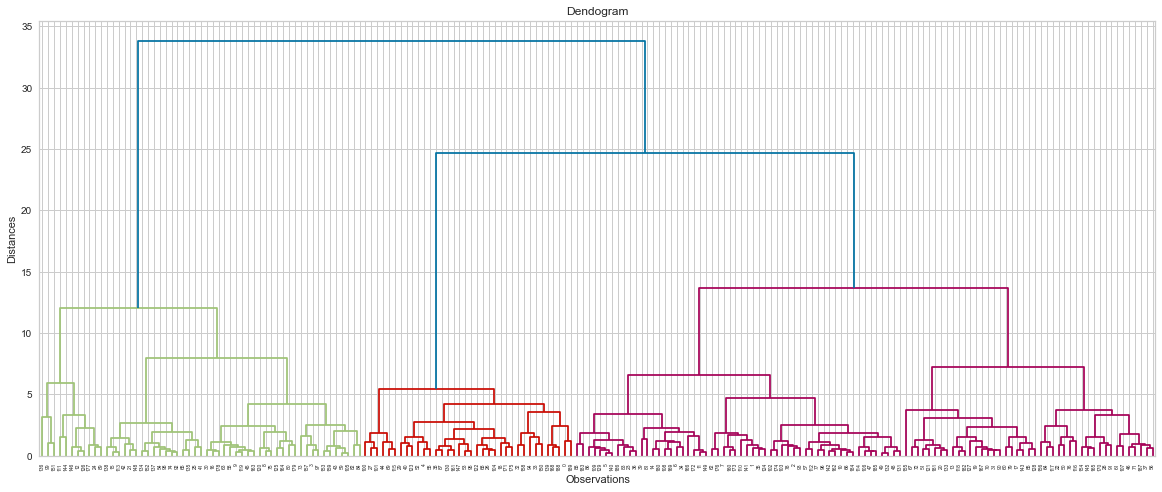

In [1272]:
plt.figure(figsize = (20,8))
plt.title("Dendogram")
plt.xlabel("Observations")
plt.ylabel("Distances")
dendrogram(linked);

In [1273]:
hc = AgglomerativeClustering (n_clusters = 3)
hc.fit_predict(df_scaled)

array([2, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 2, 0, 0, 1,
       0, 0, 1, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1,
       2, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2,
       0, 1, 0, 0, 1, 0, 2, 2, 0, 1, 1, 1, 2, 2, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 2, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1,
       0, 0, 0, 1, 2, 1, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2], dtype=int64)

In [1274]:
labels = hc.labels_

In [1275]:
np.unique(labels, return_counts=True)

(array([0, 1, 2], dtype=int64), array([99, 55, 36], dtype=int64))

In [1276]:
silhouette_score(df_scaled, labels)

0.35729658036645523

In [1277]:
df["Hc_clusters"]=labels
df.sample(5)

,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,Kmeans_clusters,Hc_clusters
location,,,,,,,,,
Lebanon,31.100000,8.5140,13367.565,5.12766,78.93,0.757000,4.772,1,0
San Marino,22.824719,5.7135,56861.470,5.30000,84.97,0.790391,6.390,1,1
Bangladesh,27.500000,5.0980,3523.984,14.80000,72.59,0.608000,4.833,1,0
Guatemala,22.900000,4.6940,7423.808,8.70000,74.30,0.650000,6.399,1,0
Spain,45.500000,19.4360,34272.360,1.00000,83.56,0.891000,6.401,0,1


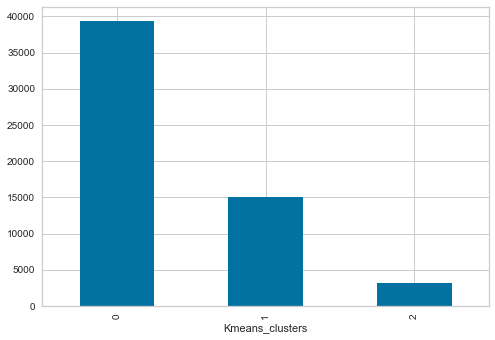

In [1278]:
df.groupby('Kmeans_clusters').gdp_per_capita.mean().plot(kind='bar');

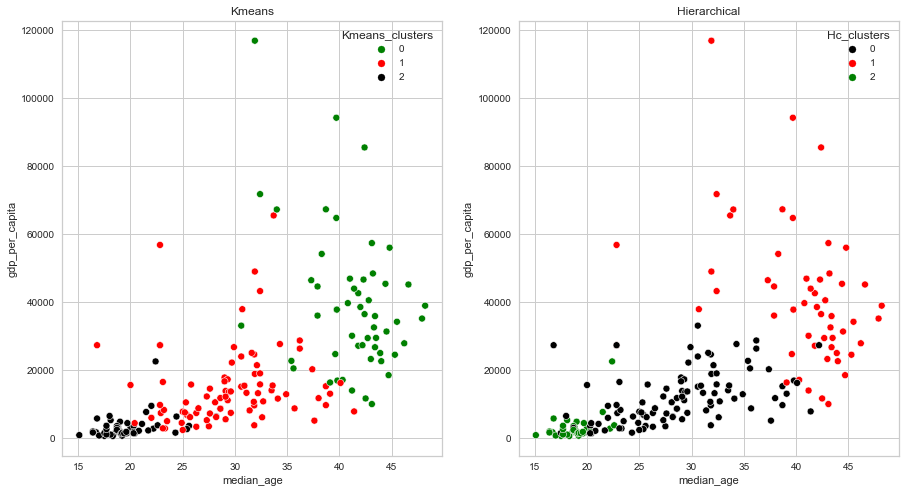

In [1279]:
plt.figure(figsize=(15,8))

plt.subplot(121)
plt.title("Kmeans")
plt.xlabel('median_age')
plt.ylabel('gdp_per_capita')
sns.scatterplot(x='median_age', y='gdp_per_capita' ,data=df, hue='Kmeans_clusters',palette=['green','red','black'])

plt.subplot(122)
plt.title("Hierarchical")
plt.xlabel('median_age')
sns.scatterplot(x='median_age', y='gdp_per_capita' ,data=df, hue='Hc_clusters',palette=['black','red','green'])
plt.show()

In [1280]:
# Alternative
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(10,6))
# ax1.set_title('Kmeans')
# ax1.set_xlabel("median_age")
# ax1.set_ylabel("gdp_per_capita")
# ax1.scatter(df.iloc[:,0], df.iloc[:,2], c = df["Kmeans_clusters"], s = 50, cmap = "rainbow")
# ax2.set_title("Hierarchical")
# ax2.set_xlabel("median_age")
# # ax2.set_ylabel("gdp_per_capita")
# ax2.scatter(df.iloc[:,0], df.iloc[:,2], c = df["Hc_clusters"], s = 50, cmap = "rainbow")
# plt.show

In [1281]:
# df.to_csv("countries_final.csv")

### Visualization of Clusters in Maps

In [1282]:
df=df.reset_index().rename(columns={'index':'location'})

In [1283]:
list_countries=df.location

import pycountry
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})

could not add ISO 3 code for -> Cape Verde
could not add ISO 3 code for -> Democratic Republic of Congo
could not add ISO 3 code for -> Laos
could not add ISO 3 code for -> South Korea
could not add ISO 3 code for -> World


In [1284]:
df['countries_abbrev']=df['location'].replace(d_country_code)
df.head()

,location,median_age,aged_65_older,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,happiness_score,Kmeans_clusters,Hc_clusters,countries_abbrev
0,Afghanistan,18.60,2.581000,1803.987000,37.120513,64.83,0.498,2.567000,2,2,AFG
1,Albania,38.00,13.188000,11803.431000,1.100000,78.57,0.785,4.883000,1,0,ALB
2,Algeria,29.10,6.211000,13913.839000,0.500000,76.88,0.754,5.005000,1,0,DZA
3,Andorra,39.75,15.823551,37844.995123,0.730556,83.73,0.858,6.373400,0,1,AND
4,Angola,16.80,2.405000,5819.495000,37.120513,61.15,0.581,4.292795,2,2,AGO


In [1285]:
df['Kmeans_clusters']=df['Kmeans_clusters'].astype('str')
df['Hc_clusters']=df['Hc_clusters'].astype('str')

In [1286]:
import plotly.express as px

fig = px.choropleth(data_frame = df,
                    locations= "countries_abbrev",
                    color= "Kmeans_clusters",  # value in column 'Confirmed' determines color
                    hover_name= "location",
                    color_continuous_scale= 'RdYlGn')

fig.show()

In [1287]:
import plotly.express as px

fig = px.choropleth(data_frame = df,
                    locations= "countries_abbrev",
                    color= "Hc_clusters",  # value in column 'Confirmed' determines color
                    hover_name= "location",
                    color_continuous_scale= 'RdYlGn')

fig.show()